In [209]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os
%matplotlib inline
#plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,FunctionTransformer,StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit, train_test_split, learning_curve,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, roc_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
rnd_state = 0

In [3]:
# create a database connection
sqluser = 'maxim'
dbname = 'maxim'
schema_name = 'mimiciii'

In [4]:
# Connect to local postgres version of mimic
connect = psycopg2.connect(dbname=dbname, user=sqluser)
cursor = connect.cursor()
cursor.execute('SET search_path to {}'.format(schema_name))

In [5]:
# Load in the query from file
query='SELECT * FROM admissions'
ad = pd.read_sql_query(query, connect)

In [6]:
ad.shape

(58976, 19)

In [7]:
ad.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,None,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaT,NaT,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,NaT,NaT,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [8]:
# Load in the query from file
query='SELECT * FROM APSIII'
aps = pd.read_sql_query(query, connect)

In [9]:
aps.shape

(61532, 21)

In [10]:
aps.head()

,subject_id,hadm_id,icustay_id,apsiii,apsiii_prob,hr_score,meanbp_score,temp_score,resprate_score,pao2_aado2_score,hematocrit_score,wbc_score,creatinine_score,uo_score,bun_score,sodium_score,albumin_score,bilirubin_score,glucose_score,acidbase_score,gcs_score
0,55973,152234,200001,63,0.188678,7.0,7.0,0.0,6.0,0.0,3.0,5.0,7.0,15.0,12.0,0.0,NaN,0.0,0.0,1.0,0.0
1,27513,163557,200003,48,0.102705,7.0,10.0,0.0,9.0,0.0,3.0,5.0,0.0,0.0,7.0,0.0,0.0,6.0,0.0,1.0,0.0
2,10950,189514,200006,23,0.033927,0.0,7.0,0.0,6.0,NaN,3.0,0.0,0.0,4.0,0.0,0.0,NaN,NaN,3.0,NaN,0.0
3,20707,129310,200007,33,0.053332,1.0,15.0,0.0,6.0,NaN,3.0,0.0,0.0,5.0,0.0,0.0,0.0,NaN,3.0,NaN,0.0
4,29904,129607,200009,26,0.038894,1.0,7.0,8.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,NaN,NaN,0.0,3.0,0.0


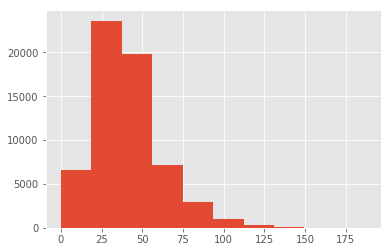

In [210]:
aps.apsiii.hist()

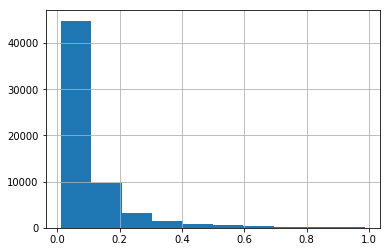

In [12]:
aps.apsiii_prob.hist()

In [13]:
f = os.path.join('/Users/maxim/Documents/ml_nanodegree/capstone/mortality_predictor_mimic/queries/apsiii_raw.sql')
with open(f) as fp:
    query = ''.join(fp.readlines())
aps_raw = pd.read_sql_query(query, connect)

In [14]:
aps_raw.head()

,subject_id,hadm_id,icustay_id,heartrate_min,heartrate_mean,heartrate_max,meanbp_min,meanbp_mean,meanbp_max,tempc_min,tempc_mean,tempc_max,resprate_min,resprate_mean,resprate_max,hematocrit_min,hematocrit_max,wbc_min,wbc_max,creatinine_min,creatinine_max,bun_min,bun_max,sodium_min,sodium_max,albumin_min,albumin_max,bilirubin_min,bilirubin_max,glucose_min,glucose_max,urineoutput,gcseyes,gcsverbal,gcsmotor,pao2,aado2
0,9514,127229,200014,58.0,71.843750,91.0,52.0,86.268525,171.000000,34.500000,35.856444,37.000000,9.0,14.378378,33.0,29.8,36.3,14.3,14.7,0.6,0.6,24.0,24.0,142.0,144.0,2.2,2.8,0.3,0.3,101.0,114.0,664.0,4.0,4.0,6.0,95.0,NaN
1,76603,179633,200024,101.0,110.571429,123.0,66.0,81.000000,100.000000,34.000000,34.300000,34.600000,18.0,20.166667,21.0,26.0,33.6,12.4,12.4,2.2,2.2,50.0,50.0,145.0,145.0,NaN,NaN,NaN,NaN,50.0,81.0,NaN,1.0,0.0,1.0,NaN,NaN
2,25225,147080,200055,72.0,86.875000,101.0,53.0,67.714286,85.000000,35.666667,36.064815,36.277778,12.0,17.833333,30.0,34.5,36.3,5.7,6.3,7.4,8.9,29.0,40.0,137.0,140.0,3.5,3.5,0.3,0.3,85.0,116.0,NaN,3.0,5.0,6.0,80.0,NaN
3,17145,105119,200068,67.0,83.625000,112.0,56.0,70.623201,84.666702,34.722222,36.904763,38.833334,20.0,22.666667,24.0,27.5,30.0,14.2,14.2,3.2,3.7,58.0,65.0,134.0,136.0,2.3,2.3,0.3,0.3,105.0,187.0,1280.0,4.0,5.0,4.0,86.0,NaN
4,52619,175374,200099,68.0,82.656250,93.0,50.0,71.500000,102.000000,36.000000,36.166667,36.444444,9.0,13.875000,22.0,28.8,34.9,8.9,9.2,1.1,1.2,20.0,20.0,138.0,140.0,NaN,NaN,NaN,NaN,84.0,258.0,955.0,3.0,5.0,6.0,88.0,NaN


In [15]:
aps_raw.shape

(61532, 37)

In [16]:
aps_raw.describe()

,subject_id,hadm_id,icustay_id,heartrate_min,heartrate_mean,heartrate_max,meanbp_min,meanbp_mean,meanbp_max,tempc_min,tempc_mean,tempc_max,resprate_min,resprate_mean,resprate_max,hematocrit_min,hematocrit_max,wbc_min,wbc_max,creatinine_min,creatinine_max,bun_min,bun_max,sodium_min,sodium_max,albumin_min,albumin_max,bilirubin_min,bilirubin_max,glucose_min,glucose_max,urineoutput,gcseyes,gcsverbal,gcsmotor,pao2,aado2
count,61532.000000,61532.000000,61532.000000,59048.000000,59048.000000,59048.000000,52288.000000,52288.000000,52288.000000,51382.000000,51382.000000,51382.000000,52229.000000,52229.000000,52229.000000,59540.000000,59540.000000,59170.000000,59170.000000,52900.000000,52900.000000,52890.000000,52890.000000,54804.000000,54804.00000,19325.000000,19325.000000,26106.000000,26106.00000,54452.000000,54452.000000,53201.000000,51988.000000,51795.000000,51734.000000,26753.000000,2887.000000
mean,33888.605912,149954.470649,249962.710248,77.499570,91.704638,109.723335,58.310360,77.906124,104.690279,36.095355,36.817087,37.470816,12.364435,18.853713,27.275403,32.036125,37.209335,11.012047,13.884411,1.325493,1.575013,24.039024,28.386141,136.661065,140.08174,3.115281,3.200476,2.043297,2.33418,103.395390,206.314501,1820.675878,3.123836,3.189439,5.168960,234.834486,456.578455
std,28127.690913,28898.895904,28890.574867,23.394808,23.126838,26.585284,13.810195,11.393066,26.097304,0.795359,0.634979,0.800570,3.767069,4.042130,6.592321,9.063132,7.534391,7.944417,10.730103,1.418212,1.718884,19.966592,22.823167,4.998585,4.64438,0.724105,0.713063,4.151604,4.64814,34.066036,4286.145576,2842.279356,1.110481,2.167278,1.627132,154.842167,129.985140
min,2.000000,100001.000000,200001.000000,0.158000,30.000000,30.000000,0.200000,17.428571,23.000000,15.000000,30.000000,30.000000,0.200000,7.000000,8.000000,4.000000,11.000000,0.100000,0.100000,0.100000,0.100000,1.000000,1.000000,1.210000,97.00000,1.000000,1.000000,0.100000,0.10000,0.106000,9.000000,-2600.000000,1.000000,0.000000,1.000000,10.000000,63.000000
25%,12047.500000,124933.750000,224935.500000,62.000000,75.892857,91.000000,51.000000,70.130435,90.000000,35.666667,36.433333,36.944444,10.000000,16.030303,23.000000,25.900000,31.900000,7.000000,9.000000,0.700000,0.800000,12.000000,14.000000,134.000000,138.00000,2.600000,2.700000,0.400000,0.40000,83.000000,129.000000,876.000000,3.000000,1.000000,5.000000,95.000000,364.000000
50%,24280.500000,149911.500000,249940.000000,72.000000,86.974521,105.000000,58.000000,76.524729,100.000000,36.111111,36.790123,37.388891,12.000000,18.190476,26.000000,30.500000,36.000000,9.740000,12.300000,0.900000,1.000000,17.000000,21.000000,137.000000,140.00000,3.100000,3.200000,0.700000,0.80000,99.000000,164.000000,1580.000000,4.000000,5.000000,6.000000,179.000000,471.000000
75%,54191.500000,174997.250000,274972.500000,86.000000,101.636364,124.000000,66.000000,84.515152,113.000000,36.555557,37.187500,37.944444,14.000000,21.034483,30.000000,36.300000,41.200000,13.400000,16.800000,1.300000,1.600000,29.000000,34.000000,140.000000,142.00000,3.600000,3.700000,1.700000,2.00000,119.000000,212.000000,2470.000000,4.000000,5.000000,6.000000,385.000000,571.000000
max,99999.000000,199999.000000,299999.000000,218.000000,244.800000,286.000000,125.000000,153.838710,299.000000,40.833333,40.833333,46.500000,47.000000,47.000000,69.000000,68.700000,74.400000,575.800000,846.700000,28.000000,46.600000,254.000000,272.000000,178.000000,182.00000,6.300000,6.300000,79.000000,82.80000,576.000000,999999.000000,561190.000000,4.000000,5.000000,6.000000,797.000000,794.000000


In [17]:
for column in aps_raw.columns:
    print(column,(aps_raw[column].isna().sum()/aps_raw.shape[0]).round(2))

subject_id 0.0
hadm_id 0.0
icustay_id 0.0
heartrate_min 0.04
heartrate_mean 0.04
heartrate_max 0.04
meanbp_min 0.15
meanbp_mean 0.15
meanbp_max 0.15
tempc_min 0.16
tempc_mean 0.16
tempc_max 0.16
resprate_min 0.15
resprate_mean 0.15
resprate_max 0.15
hematocrit_min 0.03
hematocrit_max 0.03
wbc_min 0.04
wbc_max 0.04
creatinine_min 0.14
creatinine_max 0.14
bun_min 0.14
bun_max 0.14
sodium_min 0.11
sodium_max 0.11
albumin_min 0.69
albumin_max 0.69
bilirubin_min 0.58
bilirubin_max 0.58
glucose_min 0.12
glucose_max 0.12
urineoutput 0.14
gcseyes 0.16
gcsverbal 0.16
gcsmotor 0.16
pao2 0.57
aado2 0.95


In [118]:
aps_ad = aps_raw.merge(ad,how='left',on=['hadm_id','subject_id'])
aps_ad = aps_ad.fillna(np.nan)

In [119]:
aps_ad.shape

(61532, 54)

In [232]:
features = ['heartrate_min', 'heartrate_mean', 'heartrate_max',\
            'meanbp_min', 'meanbp_mean', 'meanbp_max',\
            'tempc_min', 'tempc_mean', 'tempc_max',\
            'resprate_min', 'resprate_mean', 'resprate_max',\
            'hematocrit_min', 'hematocrit_max', 'wbc_min', 'wbc_max',\
            'creatinine_min', 'creatinine_max', 'bun_min', 'bun_max',\
            'sodium_min', 'sodium_max', 'glucose_min', 'glucose_max', 'urineoutput',\
            'gcseyes', 'gcsverbal', 'gcsmotor','hospital_expire_flag']
aps_ad = aps_ad[features]
aps_ad.loc[aps_ad.creatinine_min > 20, 'creatinine_min'] = 20
aps_ad.loc[aps_ad.creatinine_max > 20, 'creatinine_max'] = 20
aps_ad.loc[aps_ad.glucose_min > 400, 'glucose_min'] = 400
aps_ad.loc[aps_ad.glucose_max > 1000, 'glucose_max'] = 1000
aps_ad.loc[aps_ad.urineoutput < 0, 'urineoutput'] = np.nan
aps_ad.loc[aps_ad.urineoutput > 10000, 'urineoutput'] = 10000
aps_ad.loc[aps_ad.tempc_min < 32, 'tempc_min'] = np.nan
aps_ad.loc[aps_ad.tempc_min > 42, 'tempc_min'] = 42
aps_ad.loc[aps_ad.tempc_max < 32, 'tempc_max'] = np.nan
aps_ad.loc[aps_ad.tempc_max > 42, 'tempc_max'] = 42
aps_ad.loc[aps_ad.tempc_mean < 32, 'tempc_mean'] = np.nan
aps_ad.loc[aps_ad.tempc_mean > 42, 'tempc_mean'] = 42
aps_ad.loc[aps_ad.sodium_min < 100, 'sodium_min'] = 100
aps_ad.loc[aps_ad.wbc_min > 50, 'wbc_min'] = 50
aps_ad.loc[aps_ad.wbc_max > 50, 'wbc_max'] = 50

In [233]:
aps_ad.head()

,heartrate_min,heartrate_mean,heartrate_max,meanbp_min,meanbp_mean,meanbp_max,tempc_min,tempc_mean,tempc_max,resprate_min,resprate_mean,resprate_max,hematocrit_min,hematocrit_max,wbc_min,wbc_max,creatinine_min,creatinine_max,bun_min,bun_max,sodium_min,sodium_max,glucose_min,glucose_max,urineoutput,gcseyes,gcsverbal,gcsmotor,hospital_expire_flag
0,58.0,71.843750,91.0,52.0,86.268525,171.000000,34.500000,35.856444,37.000000,9.0,14.378378,33.0,29.8,36.3,14.3,14.7,0.6,0.6,24.0,24.0,142.0,144.0,101.0,114.0,664.0,4.0,4.0,6.0,0
1,101.0,110.571429,123.0,66.0,81.000000,100.000000,34.000000,34.300000,34.600000,18.0,20.166667,21.0,26.0,33.6,12.4,12.4,2.2,2.2,50.0,50.0,145.0,145.0,50.0,81.0,NaN,1.0,0.0,1.0,1
2,72.0,86.875000,101.0,53.0,67.714286,85.000000,35.666667,36.064815,36.277778,12.0,17.833333,30.0,34.5,36.3,5.7,6.3,7.4,8.9,29.0,40.0,137.0,140.0,85.0,116.0,NaN,3.0,5.0,6.0,0
3,67.0,83.625000,112.0,56.0,70.623201,84.666702,34.722222,36.904763,38.833334,20.0,22.666667,24.0,27.5,30.0,14.2,14.2,3.2,3.7,58.0,65.0,134.0,136.0,105.0,187.0,1280.0,4.0,5.0,4.0,0
4,68.0,82.656250,93.0,50.0,71.500000,102.000000,36.000000,36.166667,36.444444,9.0,13.875000,22.0,28.8,34.9,8.9,9.2,1.1,1.2,20.0,20.0,138.0,140.0,84.0,258.0,955.0,3.0,5.0,6.0,0


In [234]:
aps_ad.shape

(61532, 29)

In [235]:
aps_ad.describe()

,heartrate_min,heartrate_mean,heartrate_max,meanbp_min,meanbp_mean,meanbp_max,tempc_min,tempc_mean,tempc_max,resprate_min,resprate_mean,resprate_max,hematocrit_min,hematocrit_max,wbc_min,wbc_max,creatinine_min,creatinine_max,bun_min,bun_max,sodium_min,sodium_max,glucose_min,glucose_max,urineoutput,gcseyes,gcsverbal,gcsmotor,hospital_expire_flag
count,59048.000000,59048.000000,59048.000000,52288.000000,52288.000000,52288.000000,51289.000000,51374.000000,51376.000000,52229.000000,52229.000000,52229.000000,59540.000000,59540.000000,59170.000000,59170.000000,52900.000000,52900.000000,52890.000000,52890.000000,54804.000000,54804.00000,54452.000000,54452.000000,53201.000000,51988.000000,51795.000000,51734.000000,61532.000000
mean,77.499570,91.704638,109.723335,58.310360,77.906124,104.690279,36.107098,36.817985,37.471464,12.364435,18.853713,27.275403,32.036125,37.209335,10.903774,13.662593,1.325144,1.572985,24.039024,28.386141,136.668710,140.08174,103.365584,187.348123,1802.379060,3.123836,3.189439,5.168960,0.107408
std,23.394808,23.126838,26.585284,13.810195,11.393066,26.097304,0.736353,0.630895,0.796598,3.767069,4.042130,6.592321,9.063132,7.534391,5.984465,7.077147,1.413009,1.688409,19.966592,22.823167,4.888231,4.64438,33.757871,101.893659,1329.345451,1.110481,2.167278,1.627132,0.309633
min,0.158000,30.000000,30.000000,0.200000,17.428571,23.000000,32.000000,32.000000,32.000000,0.200000,7.000000,8.000000,4.000000,11.000000,0.100000,0.100000,0.100000,0.100000,1.000000,1.000000,100.000000,97.00000,0.106000,9.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,62.000000,75.892857,91.000000,51.000000,70.130435,90.000000,35.666667,36.433333,36.944444,10.000000,16.030303,23.000000,25.900000,31.900000,7.000000,9.000000,0.700000,0.800000,12.000000,14.000000,134.000000,138.00000,83.000000,129.000000,876.000000,3.000000,1.000000,5.000000,0.000000
50%,72.000000,86.974521,105.000000,58.000000,76.524729,100.000000,36.111111,36.790123,37.388891,12.000000,18.190476,26.000000,30.500000,36.000000,9.740000,12.300000,0.900000,1.000000,17.000000,21.000000,137.000000,140.00000,99.000000,164.000000,1580.000000,4.000000,5.000000,6.000000,0.000000
75%,86.000000,101.636364,124.000000,66.000000,84.515152,113.000000,36.555557,37.187500,37.944444,14.000000,21.034483,30.000000,36.300000,41.200000,13.400000,16.800000,1.300000,1.600000,29.000000,34.000000,140.000000,142.00000,119.000000,212.000000,2470.000000,4.000000,5.000000,6.000000,0.000000
max,218.000000,244.800000,286.000000,125.000000,153.838710,299.000000,40.833333,40.833333,42.000000,47.000000,47.000000,69.000000,68.700000,74.400000,50.000000,50.000000,20.000000,20.000000,254.000000,272.000000,178.000000,182.00000,400.000000,1000.000000,10000.000000,4.000000,5.000000,6.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a5e4ffcf8>,
      dtype=object)

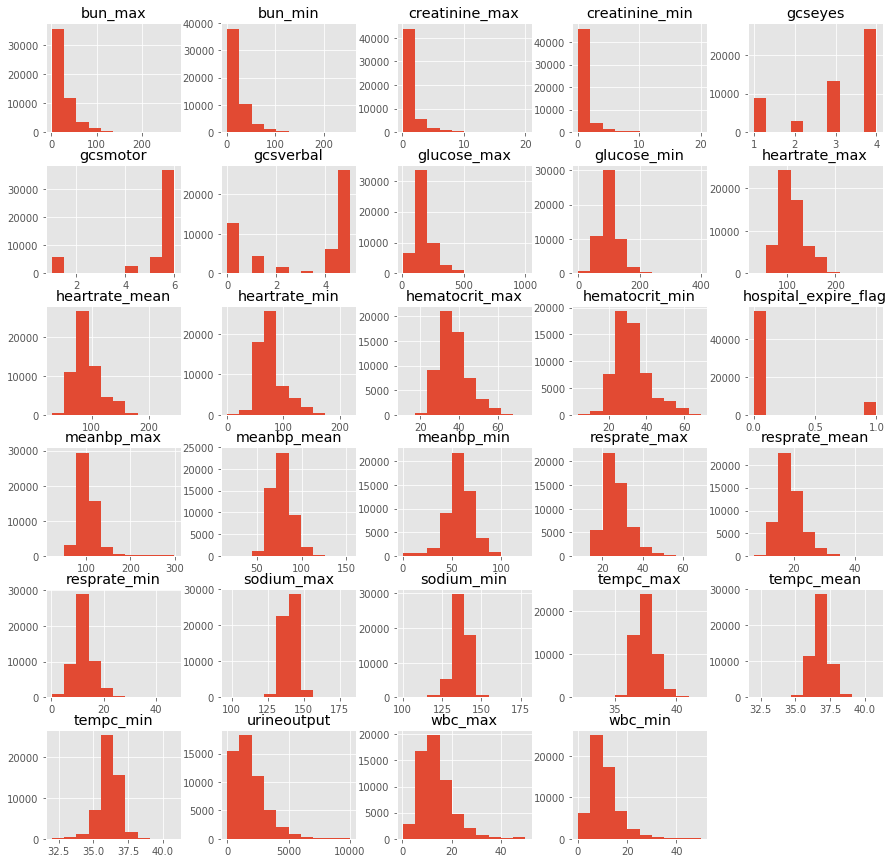

In [236]:
aps_ad.hist(figsize=(15,15))

In [237]:
num_features = ['heartrate_min', 'heartrate_mean', 'heartrate_max',\
            'meanbp_min', 'meanbp_mean', 'meanbp_max',\
            'tempc_min', 'tempc_mean', 'tempc_max',\
            'resprate_min', 'resprate_mean', 'resprate_max',\
            'hematocrit_min', 'hematocrit_max', 'wbc_min', 'wbc_max',\
            'creatinine_min', 'creatinine_max', 'bun_min', 'bun_max',\
            'sodium_min', 'sodium_max', 'glucose_min', 'glucose_max', 'urineoutput',\
            'gcseyes', 'gcsverbal', 'gcsmotor']
X = aps_ad[num_features]
y = aps_ad.hospital_expire_flag
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, test_size=0.2, \
                                                    shuffle=True, stratify=y, random_state=rnd_state)


In [238]:
print('Shape of training set: {}'.format(X_train_orig.shape))
print('Shape of test set: {}'.format(X_test_orig.shape))
print('Number of positives in training set: {}'.format(y_train.sum()))
print('Number of positives in test set: {}'.format(y_test.sum()))

Shape of training set: (49225, 28)
Shape of test set: (12307, 28)
Number of positives in training set: 5287
Number of positives in test set: 1322


In [239]:
num_impute = ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median'))
scale = ('scale', MinMaxScaler())
num_transformer = Pipeline([num_impute, scale])

preprocessor = ColumnTransformer(transformers=[('num', num_transformer, num_features)])

X_train = preprocessor.fit_transform(X_train_orig)
X_test = preprocessor.transform(X_test_orig)

In [240]:
lr = LogisticRegression(random_state=rnd_state,solver='lbfgs',max_iter=1000,class_weight='balanced',C=1.0,tol=0.0001)

lr.fit(X_train, y_train)

predictions = lr.predict(X_test)
logit = np.dot(lr.coef_,X_test.T)
probabilities = np.exp(logit)/(1.+np.exp(logit))

F1 = f1_score(y_test, predictions)
auroc = roc_auc_score(y_test, probabilities[0])
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
res = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
print(res)

TEST SET f1: 0.40 auroc: 0.84 precision: 0.28 recall: 0.74


In [241]:
apsiii = aps.merge(ad,how='left',on=['hadm_id','subject_id'])
#apsiii.head()

In [242]:
aps_predictions = apsiii.apsiii_prob.values
aps_binary_predictions = apsiii.apsiii_prob.round().values
y_full = apsiii.hospital_expire_flag.values
F1 = f1_score(y_full, aps_binary_predictions)
auroc = roc_auc_score(y_full, aps_predictions)
precision = precision_score(y_full, aps_binary_predictions)
recall = recall_score(y_full, aps_binary_predictions)
res = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
print(res)

TEST SET f1: 0.23 auroc: 0.80 precision: 0.65 recall: 0.14


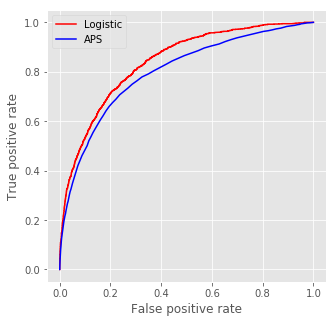

In [248]:
f, axs = plt.subplots(1,1,figsize=(5,5))

x,y,_ = roc_curve(y_test, probabilities[0])
plt.plot(x,y,label='Logistic',color='red')
x,y,_ = roc_curve(y_full, aps_predictions)
plt.plot(x,y,label='APS',color='blue')
plt.legend(loc='best')
axs.set_xlabel('False positive rate')
axs.set_ylabel('True positive rate')

plt.savefig('logisic_aps.pdf')

# Neural network

In [177]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [174]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

In [175]:
from torch.utils import data
class Dataset(data.Dataset):
    
  def __init__(self, X, y):
        'Initialization'
        self.X = X
        self.y = y

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

  def __getitem__(self, index):
        'Generates one sample of data'

        X = self.X[index]
        y = self.y[index]

        return X, y

In [178]:
# obtain training indices that will be used for validation
num_train = len(X_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(Dataset(X_train,y_train.values), batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(Dataset(X_train,y_train.values), batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(Dataset(X_test,y_test.values), batch_size=batch_size, 
    num_workers=num_workers)

In [181]:
X_train.shape

(49225, 28)

In [188]:
# define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (10)
        hidden = 256
        # linear layer (10 -> hidden_1)
        self.fc1 = nn.Linear(28, hidden)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden, 1)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        #x = x.view(-1, 1)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=28, out_features=384, bias=True)
  (fc2): Linear(in_features=384, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [202]:
# define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (10)
        hidden = 256
        # linear layer (10 -> hidden_1)
        self.fc1 = nn.Linear(28, hidden)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)

        # linear layer (n_hidden -> 1)
        self.fc4 = nn.Linear(hidden, 1)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc4(x)
        x = torch.sigmoid(x)
        #x = x.view(-1, 1)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=28, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [203]:
# specify loss function (categorical cross-entropy)
#criterion = nn.CrossEntropyLoss()

criterion = nn.BCELoss()
# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [204]:
# number of epochs to train the model
n_epochs = 50

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        # calculate the loss
        target = target.view(-1,1)
        weight=compute_sample_weight(class_weight='balanced', y=target)
        weight=torch.Tensor(weight)
        weight=weight.view(-1,1)
        criterion.weight = weight
        loss = criterion(output.float(), target.float())
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.float())
        # calculate the loss
        target = target.view(-1,1)
        weight=compute_sample_weight(class_weight='balanced', y=target)
        weight=torch.Tensor(weight)
        weight=weight.view(-1,1)
        criterion.weight = weight
        loss = criterion(output.float(), target.float())
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.527005 	Validation Loss: 0.120549
Validation loss decreased (inf --> 0.120549).  Saving model ...
Epoch: 2 	Training Loss: 0.457723 	Validation Loss: 0.105811
Validation loss decreased (0.120549 --> 0.105811).  Saving model ...
Epoch: 3 	Training Loss: 0.429393 	Validation Loss: 0.102989
Validation loss decreased (0.105811 --> 0.102989).  Saving model ...
Epoch: 4 	Training Loss: 0.414330 	Validation Loss: 0.099631
Validation loss decreased (0.102989 --> 0.099631).  Saving model ...
Epoch: 5 	Training Loss: 0.410517 	Validation Loss: 0.097522
Validation loss decreased (0.099631 --> 0.097522).  Saving model ...
Epoch: 6 	Training Loss: 0.403432 	Validation Loss: 0.095472
Validation loss decreased (0.097522 --> 0.095472).  Saving model ...
Epoch: 7 	Training Loss: 0.400978 	Validation Loss: 0.096088
Epoch: 8 	Training Loss: 0.398420 	Validation Loss: 0.095848
Epoch: 9 	Training Loss: 0.395215 	Validation Loss: 0.094581
Validation loss decreased (0.095472 --> 0.

In [205]:
model = Net()
model.load_state_dict(torch.load('model.pt'))
model.eval()

Net(
  (fc1): Linear(in_features=28, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [206]:
#model.eval() # prep model for evaluation
test_loss = 0.0
predictions = []
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data.float())
    predictions += output.view(1,-1).tolist()[0]

binary_predictions = np.round(predictions)

In [207]:
F1 = f1_score(y_test, binary_predictions)
auroc = roc_auc_score(y_test, predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
res = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
print(res)

TEST SET f1: 0.50 auroc: 0.87 precision: 0.38 recall: 0.73


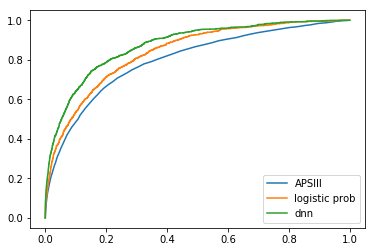

In [208]:
x,y,_ = roc_curve(y_full, aps_predictions)
plt.plot(x,y,label='APSIII')
x,y,_ = roc_curve(y_test, probabilities[0])
plt.plot(x,y,label='logistic prob')
x,y,_ = roc_curve(y_test, predictions)
plt.plot(x,y,label='dnn')
plt.legend(loc='best')

In [ ]:
TEST SET f1: 0.46 auroc: 0.86 precision: 0.33 recall: 0.75

TEST SET f1: 0.46 auroc: 0.86 precision: 0.34 recall: 0.71


In [211]:
aps_ad.head()

,heartrate_min,heartrate_mean,heartrate_max,meanbp_min,meanbp_mean,meanbp_max,tempc_min,tempc_mean,tempc_max,resprate_min,resprate_mean,resprate_max,hematocrit_min,hematocrit_max,wbc_min,wbc_max,creatinine_min,creatinine_max,bun_min,bun_max,sodium_min,sodium_max,glucose_min,glucose_max,urineoutput,gcseyes,gcsverbal,gcsmotor,hospital_expire_flag
0,58.0,71.843750,91.0,52.0,86.268525,171.000000,34.500000,35.856444,37.000000,9.0,14.378378,33.0,29.8,36.3,14.3,14.7,0.6,0.6,24.0,24.0,142.0,144.0,101.0,114.0,664.0,4.0,4.0,6.0,0
1,101.0,110.571429,123.0,66.0,81.000000,100.000000,34.000000,34.300000,34.600000,18.0,20.166667,21.0,26.0,33.6,12.4,12.4,2.2,2.2,50.0,50.0,145.0,145.0,50.0,81.0,NaN,1.0,0.0,1.0,1
2,72.0,86.875000,101.0,53.0,67.714286,85.000000,35.666667,36.064815,36.277778,12.0,17.833333,30.0,34.5,36.3,5.7,6.3,7.4,8.9,29.0,40.0,137.0,140.0,85.0,116.0,NaN,3.0,5.0,6.0,0
3,67.0,83.625000,112.0,56.0,70.623201,84.666702,34.722222,36.904763,38.833334,20.0,22.666667,24.0,27.5,30.0,14.2,14.2,3.2,3.7,58.0,65.0,134.0,136.0,105.0,187.0,1280.0,4.0,5.0,4.0,0
4,68.0,82.656250,93.0,50.0,71.500000,102.000000,36.000000,36.166667,36.444444,9.0,13.875000,22.0,28.8,34.9,8.9,9.2,1.1,1.2,20.0,20.0,138.0,140.0,84.0,258.0,955.0,3.0,5.0,6.0,0


In [212]:
aps_ad_2 = aps.merge(ad,how='left',on=['hadm_id','subject_id'])
aps_ad_2.head()

,subject_id,hadm_id,icustay_id,apsiii,apsiii_prob,hr_score,meanbp_score,temp_score,resprate_score,pao2_aado2_score,hematocrit_score,wbc_score,creatinine_score,uo_score,bun_score,sodium_score,albumin_score,bilirubin_score,glucose_score,acidbase_score,gcs_score,row_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,55973,152234,200001,63,0.188678,7.0,7.0,0.0,6.0,0.0,3.0,5.0,7.0,15.0,12.0,0.0,NaN,0.0,0.0,1.0,0.0,44912,2181-11-18 16:04:00,2181-12-04 13:42:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,SNF,Medicare,ENGL,MUSLIM,SINGLE,ASIAN - ASIAN INDIAN,2181-11-18 10:32:00,2181-11-18 17:19:00,CELLULITIS,0,1
1,27513,163557,200003,48,0.102705,7.0,10.0,0.0,9.0,0.0,3.0,5.0,0.0,0.0,7.0,0.0,0.0,6.0,0.0,1.0,0.0,33638,2199-08-02 17:02:00,2199-08-22 19:00:00,NaT,EMERGENCY,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,PTUN,PROTESTANT QUAKER,MARRIED,WHITE,NaT,NaT,S/P RESECTION,0,1
2,10950,189514,200006,23,0.033927,0.0,7.0,0.0,6.0,NaN,3.0,0.0,0.0,4.0,0.0,0.0,NaN,NaN,3.0,NaN,0.0,13396,2159-09-03 11:27:00,2159-09-05 18:45:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicaid,None,NOT SPECIFIED,MARRIED,OTHER,2159-09-03 08:56:00,2159-09-03 13:57:00,TRACH OCCLUSION,0,1
3,20707,129310,200007,33,0.053332,1.0,15.0,0.0,6.0,NaN,3.0,0.0,0.0,5.0,0.0,0.0,0.0,NaN,3.0,NaN,0.0,25280,2109-02-17 10:02:00,2109-02-20 15:47:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,CATHOLIC,MARRIED,WHITE,2109-02-17 06:28:00,2109-02-17 11:15:00,RULE-OUT MYOCARDIAL INFARCTION,0,1
4,29904,129607,200009,26,0.038894,1.0,7.0,8.0,0.0,0.0,3.0,0.0,0.0,4.0,0.0,0.0,NaN,NaN,0.0,3.0,0.0,36436,2189-11-30 10:45:00,2189-12-06 15:00:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,CATHOLIC,MARRIED,WHITE,NaT,NaT,"MITRAL REGURGITATION\MITRAL VALVE REPLACEMENT,...",0,1


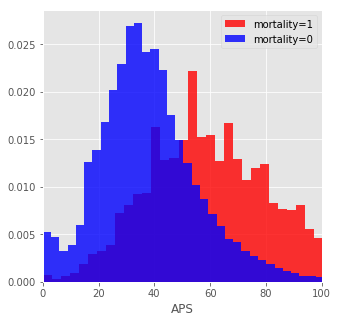

In [222]:
f, axs = plt.subplots(1,1,figsize=(5,5))

axs.hist(aps_ad_2.loc[aps_ad_2.hospital_expire_flag == 1].apsiii,density=1,color='red',label='mortality=1',bins=57,alpha=0.8)
axs.hist(aps_ad_2.loc[aps_ad_2.hospital_expire_flag == 0].apsiii,density=1,color='blue',label='mortality=0',bins=63,alpha=0.8)
axs.legend(loc='best')
axs.set_xlim(0,100)
axs.set_xlabel('APS')

plt.savefig('APS.pdf')

In [219]:
# Load in the query from file
query='SELECT * FROM OASIS'
oasis = pd.read_sql_query(query, connect)
oasis = oasis.dropna(axis=0)
oasis = oasis.loc[(oasis.urineoutput < 20000) & (oasis.urineoutput > 0) & 
                  (oasis.temp > 30) & (oasis.temp < 45) & (oasis.icustay_age_group == 'adult')]
oasis['preiculos_hours'] = oasis.preiculos.dt.total_seconds()/3600

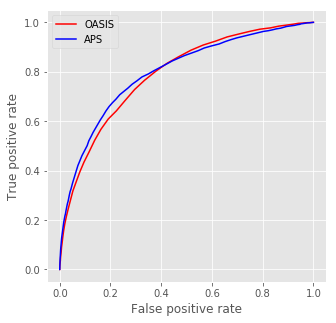

In [225]:
f, axs = plt.subplots(1,1,figsize=(5,5))

a,b,c = roc_curve(oasis.hospital_expire_flag, oasis.oasis_prob)
axs.plot(a,b,label='OASIS',color='red')
a,b,c = roc_curve(aps_ad_2.hospital_expire_flag, aps_ad_2.apsiii_prob)
axs.plot(a,b,label='APS',color='blue')
axs.legend(loc='best')
axs.set_xlabel('False positive rate')
axs.set_ylabel('True positive rate')
plt.savefig('roc_oasis_aps.pdf')

In [230]:
F1 = f1_score(oasis.hospital_expire_flag, oasis.oasis_prob.round())
auroc = roc_auc_score(oasis.hospital_expire_flag, oasis.oasis_prob)
precision = precision_score(oasis.hospital_expire_flag, oasis.oasis_prob.round())
recall = recall_score(oasis.hospital_expire_flag, oasis.oasis_prob.round())
res = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
print(res)

TEST SET f1: 0.28 auroc: 0.79 precision: 0.55 recall: 0.18


In [231]:
F1 = f1_score(aps_ad_2.hospital_expire_flag, aps_ad_2.apsiii_prob.round())
auroc = roc_auc_score(aps_ad_2.hospital_expire_flag, aps_ad_2.apsiii_prob)
precision = precision_score(aps_ad_2.hospital_expire_flag, aps_ad_2.apsiii_prob.round())
recall = recall_score(aps_ad_2.hospital_expire_flag, aps_ad_2.apsiii_prob.round())
res = 'TEST SET f1: {0:.2f} auroc: {1:.2f} precision: {2:.2f} recall: {3:.2f}'.format(F1,auroc,precision,recall)
print(res)

TEST SET f1: 0.23 auroc: 0.80 precision: 0.65 recall: 0.14
